In [19]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import os, glob
import numpy as np
import datetime as dt
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.stem.lancaster import LancasterStemmer
pd.set_option('display.max_colwidth', None)

date = datetime.now().strftime("%Y-%m-%d")
firstdateoftheyear = datetime(int(datetime.now().strftime("%Y")), 1,1).strftime("%Y-%m-%d")
lastweek = (dt.date.today() + dt.timedelta(days=-dt.date.today().weekday()) - dt.timedelta(days = 7)).strftime("%Y-%m-%d")
last30days = (dt.date.today() + dt.timedelta(days=-dt.date.today().weekday()) - dt.timedelta(days = 30)).strftime("%Y-%m-%d")
excludem = '^tokocrypto$|^indodax$|^pintu_id$|^pintuid$|^rekeningkuasset$|^rekuid$|^reku_id$|^kripto$|^crypto$'

In [20]:
def stopword(x):
  factory = StopWordRemoverFactory()
  swsas = factory.get_stop_words()
  swnltk = stopwords.words(['english','indonesian'])
  sw = [\
        '1','2','3','4','5','6','7','8','9','0',\
        'kripto','crypto',\
        'bikin','biar','udah','kalo','kalo','gue','sih','emang','mohon','pake','en','dah','tau','zipmex',\
        'zipmexindonesia','gimana','loh','sampe','banget','kah','ga',\
        'asetmasadepan','cmc','aplikasipintu','salamtothemoon','deh', 'dm','hi', 'hai', 'kakak',\
        'pintuid','rekeningku','zipmex', 'pintu', 'upbit', 'tokocrypto','indodax', 'ya','token',\
        'ceo','tkolock','crypto','lock','udh','dont', 'hey', 'baby','rt', 'tuh','amp','sir','tko',\
        'bos','aja','gak','nih','nya','min','ud','cm','kak','bang','ntar','yg','nii', 'utc', 'x']+ swnltk\
        + list(STOPWORDS) + list(x[x['Type'].str.contains("Mention|Hashtag")]["word"].unique())
  swdf = pd.DataFrame(sw).drop_duplicates()
  swdf.columns = ["word"]
  swdf['word'] = swdf['word'].str.replace('[^\w\s]','', regex=True)
  return swdf

In [21]:
# topik = input("Pilih topik")
# date_begin = input("Pilih tanggal mulai (YYYY-MM-DD)")
# date_end = input("Pilih tanggal selesai (YYYY-MM-DD)")
# limit = input("berapa banyak data?")
# language = input("select lang:")

In [22]:
topik = "kripto crypto"
date_begin = last30days
date_end = date
limit = 1000
language = "in en"
langs = language.split()

tweets_list1 = []
tweets_list2 = []
for i in langs:
    query = f"{topik} since:{date_begin} until:{date_end} lang:{i}"

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{query}').get_items()):
        if i>int(limit):
            break
        tweets_list1.append(tweet)
        tweets_list2.append([tweet.url, tweet.user.followersCount, tweet.user.friendsCount, tweet.user.verified])
        
    # Creating a dataframe from the tweets list above
    tl1 = pd.DataFrame(tweets_list1)
    tl2 = pd.DataFrame(tweets_list2,\
            columns = ['url', 'followers', 'friends', 'verified'])

    data = pd.merge(tl1, tl2, on = 'url')

    data.rename(columns = {'rawContent': 'text', 'sourceLabel':'source (platform)',\
        'replyCount':'replied','retweetCount':'retweeted','quoteCount':'quoted',\
        'likeCount':'liked', 'inReplyToTweetId': 'reply to'}, inplace=True)

    data['reply to'] = data['reply to'].fillna(0).apply(np.int64).apply(str).replace("0","")
    data['post type'] = np.where(data['quotedTweet'].notnull()==True, "share",\
        np.where((data['reply to']!="") & (data['quotedTweet'].isnull()==True),"reply","post"))

    data = data[['date', 'url','text', 'lang', 'source (platform)', 'verified', 'post type', 'reply to',\
        'replied','retweeted', 'quoted', 'liked', 'followers', 'friends']]
    # return data

In [23]:
wordings = data.copy()

wordings['word'] = wordings['text'].str.lower()\
    .str.replace('#|#\n',' #', regex=True).str.replace('@|@\n',' @', regex=True)\
    .str.split()
wordings = wordings.explode('word')
wordings = wordings[~(wordings['word'].str.contains('https'))]
wordings['word'] = wordings['word'].str.replace('[^A-Za-z #@]',' ', regex=True)
wordings = wordings[wordings['word'].str.contains(" ")==False]
wordings['Type'] = np.where(wordings['word'].str.startswith("#"), "hashtag",\
    np.where(wordings['word'].str.contains("@"), "mention", "word"))

swdf = stopword(wordings)
st = LancasterStemmer()
factory = StemmerFactory()
indo = factory.create_stemmer()

wordings_new = pd.merge(wordings, swdf, how='outer', on = 'word', indicator=True).drop_duplicates()
wordings_new['word'] = np.where((wordings_new['lang']=='en') & (wordings_new['Type']=="word"), wordings_new['word'].apply(lambda y: st.stem(y)),\
    np.where((wordings_new['lang']=='in') & (wordings_new['Type']=="word"), wordings_new['word'].apply(lambda y: indo.stem(y)),wordings_new['word']))
wordings_new = wordings_new[(wordings_new['_merge'] == 'left_only')].drop(columns="_merge")
hashnmention_new = wordings[(wordings['Type'] != 'word') & ~(wordings['word'].str.replace('@|#','', regex=True).str.contains(excludem))]

ov_wordings_word = wordings_new[(wordings_new['Type']=="word")].\
    groupby(['word']).count().add_prefix('count_').reset_index()[['word','count_url']]
ov_wordings_word.columns = ['word', 'count_word']
ov_wordings_total = wordings_new[(wordings_new['Type']=="word")].\
    groupby(['word']).sum(numeric_only=True).add_prefix('sum_').reset_index()

ov_wordings = pd.merge(ov_wordings_total,ov_wordings_word).sort_values(by='word', ascending=False)\
    [['word','count_word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_wordings.rename(columns = {'count_word':'total word',\
    'sum_retweeted':'retweeted','sum_quoted':'quoted',\
    'sum_liked':'liked'}, inplace=True)

ov_hash_total = hashnmention_new[(hashnmention_new['Type']=="hashtag")].\
    groupby(['word']).sum(numeric_only=True).add_prefix('sum_').reset_index()[['word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_hash_word = hashnmention_new[(hashnmention_new['Type']=="hashtag")].\
    groupby(['word']).count().add_prefix('count_').reset_index()[['word', 'count_url']]
ov_hash_word.columns = ['word', 'count_word']

ov_hash = pd.merge(ov_hash_total,ov_hash_word).sort_values(by='count_word', ascending=False)\
    [['word', 'count_word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_hash['word'] = ov_hash['word'].replace("#","", regex=True)

ov_hash.rename(columns = {'word': 'hashtag', 'count_word':'total hashtags',\
    'sum_retweeted':'retweeted','sum_quoted':'quoted',\
    'sum_liked':'liked'}, inplace=True)

ov_mention_total = hashnmention_new[(hashnmention_new['Type']=="mention")].\
    groupby(['word']).sum(numeric_only=True).add_prefix('sum_').reset_index()[['word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_mention_word = hashnmention_new[(hashnmention_new['Type']=="mention")].\
    groupby(['word']).count().add_prefix('count_').reset_index()[['word', 'count_url']]
ov_mention_word.columns = ['word', 'count_word']

ov_mention = pd.merge(ov_mention_total,ov_mention_word).sort_values(by='count_word', ascending=False)\
    [['word', 'count_word', 'sum_retweeted', 'sum_quoted', 'sum_liked']]

ov_mention['word'] = ov_mention['word'].replace("@","", regex=True)

ov_mention.rename(columns = {'word': 'mention', 'count_word':'total mentions',\
    'sum_retweeted':'retweeted','sum_quoted':'quoted',\
    'sum_liked':'liked'}, inplace=True)

# return wordings_new, hashnmention_new, ov_wordings, ov_hash, ov_mention

In [24]:
ov_wordings.sort_values(by='total word', ascending = False).head(10)

,word,total word,retweeted,quoted,liked
732,follow,204,1850.0,27.0,4445.0
1652,pleas,194,171.0,7.0,1586.0
241,bin,174,200.0,6.0,1844.0
2201,top,169,58.0,1.0,200.0
918,hour,166,20.0,0.0,115.0
1428,mov,163,7.0,0.0,82.0
1810,report,163,7.0,0.0,82.0
1479,next,72,90.0,5.0,656.0
127,aset,71,28.0,7.0,115.0
1475,new,59,520.0,1.0,1576.0


In [25]:
ov_hash.sort_values(by='total hashtags', ascending = False).head(10)

,hashtag,total hashtags,retweeted,quoted,liked
84,bitcoin,602,1184,36,4729
112,btc,572,3811,86,12072
77,binance,470,1205,43,4248
262,eth,458,773,26,4405
178,cryptocurrency,273,419,57,4614
519,nft,249,775,28,2739
321,giveaway,247,235,9,2162
263,ethereum,234,1256,12,1996
635,sol,213,218,12,2255
173,cryptobox,206,191,7,1689


In [26]:
ov_mention.sort_values(by='total mentions', ascending = False).head(10)

,mention,total mentions,retweeted,quoted,liked
147,huobiturkiye,15,23,0,15
144,hoteliercrypto,10,1,1,4
106,elonmusk,8,0,0,12
29,binance,8,15,1,24
171,kingofpara,7,1,0,2
78,cryptojack,7,0,0,11
299,themooncarl,7,6,0,10
324,watcherguru,7,6,0,20
325,wearesaitama,7,1,0,4
204,martiniguyyt,6,6,0,20


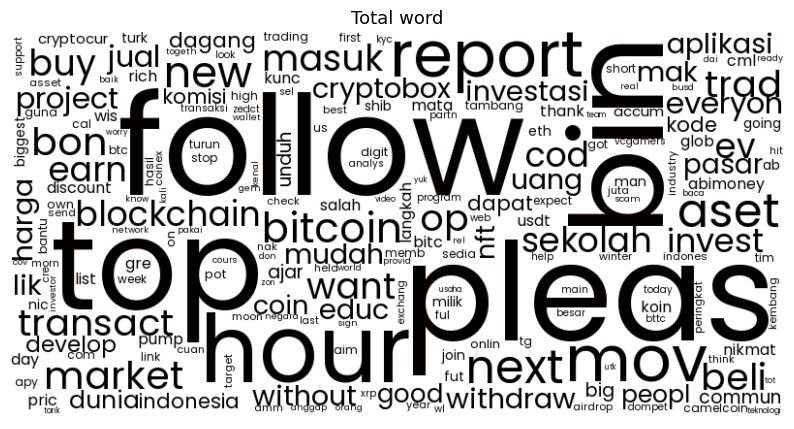

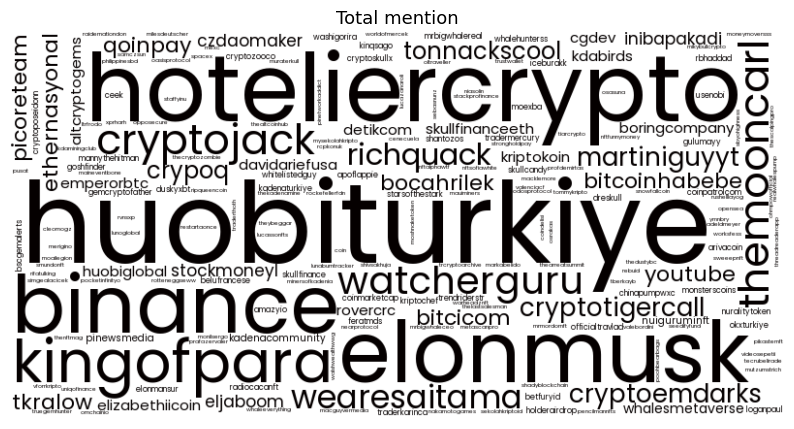

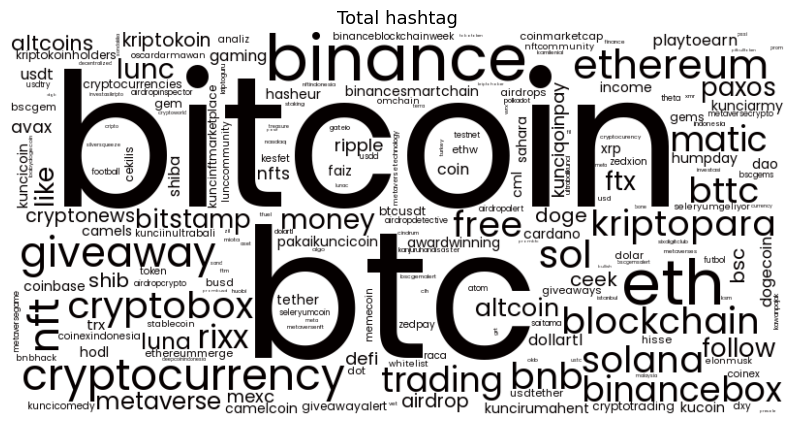

In [27]:
def black(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

def green(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(125, 62%, 37%)")

def blue(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(240,100%,50%)")

def white(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 100%)")

font = 'D:/Documents/Programming/Python/Sentiments/Sources/Font/Poppins-Regular.ttf'
words_max = 200

ov_wordings_dict = ov_wordings.set_index('word').to_dict()['total word']
wc = WordCloud(font_path = font, width=800, height=400, max_words=words_max, background_color="white").\
    generate_from_frequencies(ov_wordings_dict).recolor(color_func = black)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Total word", fontsize=13)
plt.axis('off')
plt.show()

ov_mention_dict = ov_mention.set_index('mention').to_dict()['total mentions']
wc = WordCloud(font_path = font, width=800, height=400, max_words=words_max, background_color="white").\
    generate_from_frequencies(ov_mention_dict).recolor(color_func = black)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Total mention", fontsize=13)
plt.axis('off')
plt.show()

ov_hash_dict = ov_hash.set_index('hashtag').to_dict()['total hashtags']
wc = WordCloud(font_path = font, width=800, height=400, max_words=words_max, background_color="white").\
    generate_from_frequencies(ov_hash_dict).recolor(color_func = black)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.title("Total hashtag", fontsize=13)
plt.axis('off')
plt.show()